## Task-3: Variational Autoencoder (VAE)

In [1]:
# Required imports and setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# MNIST DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)} | Test: {len(test_dataset)}")

Train: 60000 | Test: 10000


In [3]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),    # 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),   # 7
            nn.ReLU(),
            nn.Conv2d(64, 128, 7, 1, 0),  # 1
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 7, 1, 0),  # 7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),    # 28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 128, 1, 1)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [4]:
# Loss Function
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [5]:
# Training Function
def train_vae(model, train_loader, test_loader, epochs=50, latent_dim=128):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Test
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                recon, mu, logvar = model(x)
                test_loss += vae_loss(recon, x, mu, logvar).item()

        train_loss /= len(train_loader.dataset)
        test_loss  /= len(test_loader.dataset)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)

        print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

    return history

In [6]:
# Visualization Functions
def show_images(imgs, title):
    imgs = imgs.cpu().detach()
    grid = make_grid(imgs, nrow=8, normalize=True)
    plt.figure(figsize=(10, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

def reconstruct(model, loader):
    model.eval()
    x, _ = next(iter(loader))
    x = x[:8].to(device)
    with torch.no_grad():
        recon, _, _ = model(x)
    show_images(torch.cat([x, recon]), "Original (Top) vs Reconstructed (Bottom)")

def generate(model, n=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, model.latent_dim).to(device)
        samples = model.decode(z)
    show_images(samples, f"Generated Samples (z ~ N(0,1))")

def interpolate(model, loader):
    model.eval()
    x1, _ = next(iter(loader))
    x2, _ = next(iter(loader))
    x1, x2 = x1[0:1].to(device), x2[0:1].to(device)

    with torch.no_grad():
        mu1, logvar1 = model.encode(x1)
        mu2, logvar2 = model.encode(x2)
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)

    alphas = torch.linspace(0, 1, 10).to(device)
    interpolations = []
    for alpha in alphas:
        z = (1 - alpha) * z1 + alpha * z2
        img = model.decode(z)
        interpolations.append(img)

    show_images(torch.cat(interpolations), "Latent Space Interpolation")

In [7]:
# Train VAE with latent_dim = 128
print("Training VAE (latent_dim = 128)...")
vae_128 = VAE(latent_dim=128)
hist_128 = train_vae(vae_128, train_loader, test_loader, epochs=50, latent_dim=128)

Training VAE (latent_dim = 128)...
Epoch  1 | Train Loss: 195.7666 | Test Loss: 148.8895
Epoch  2 | Train Loss: 132.7278 | Test Loss: 119.3024
Epoch  3 | Train Loss: 115.9272 | Test Loss: 111.6590
Epoch  4 | Train Loss: 110.2462 | Test Loss: 107.3820
Epoch  5 | Train Loss: 106.8104 | Test Loss: 105.8133
Epoch  6 | Train Loss: 105.0149 | Test Loss: 103.9605
Epoch  7 | Train Loss: 103.8522 | Test Loss: 102.7410
Epoch  8 | Train Loss: 102.9118 | Test Loss: 101.9337
Epoch  9 | Train Loss: 102.0534 | Test Loss: 101.3101
Epoch 10 | Train Loss: 101.3924 | Test Loss: 100.9053
Epoch 11 | Train Loss: 100.7475 | Test Loss: 100.4048
Epoch 12 | Train Loss: 100.2615 | Test Loss: 100.0765
Epoch 13 | Train Loss: 99.9540 | Test Loss: 99.6319
Epoch 14 | Train Loss: 99.6015 | Test Loss: 99.3265
Epoch 15 | Train Loss: 99.2153 | Test Loss: 99.5858
Epoch 16 | Train Loss: 98.9538 | Test Loss: 98.8417
Epoch 17 | Train Loss: 98.7286 | Test Loss: 98.9740
Epoch 18 | Train Loss: 98.5267 | Test Loss: 98.8525
Epoch

Reconstruction (128)


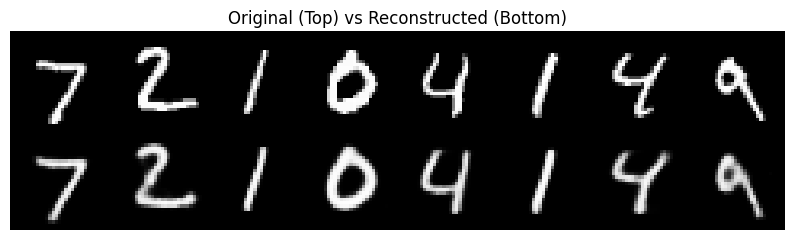

Generation (128)


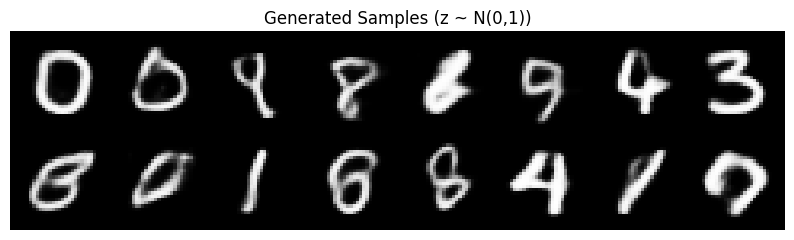

Interpolation (128)


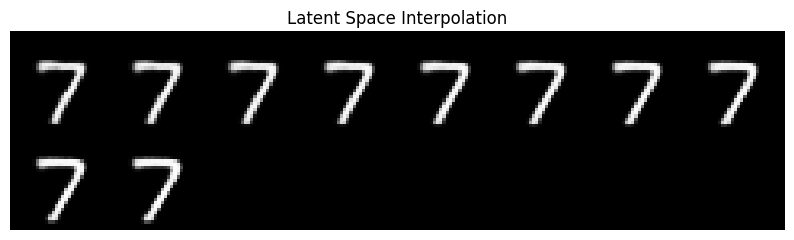

In [8]:
# Visualizations for latent_dim = 128
print("Reconstruction (128)")
reconstruct(vae_128, test_loader)

print("Generation (128)")
generate(vae_128)

print("Interpolation (128)")
interpolate(vae_128, test_loader)

In [9]:
# Train VAE with latent_dim = 256
print("\nTraining VAE (latent_dim = 256)...")
vae_256 = VAE(latent_dim=256)
hist_256 = train_vae(vae_256, train_loader, test_loader, epochs=50, latent_dim=256)


Training VAE (latent_dim = 256)...
Epoch  1 | Train Loss: 205.8051 | Test Loss: 160.2405
Epoch  2 | Train Loss: 146.7886 | Test Loss: 131.6621
Epoch  3 | Train Loss: 123.3176 | Test Loss: 116.8754
Epoch  4 | Train Loss: 115.3705 | Test Loss: 112.5029
Epoch  5 | Train Loss: 111.4695 | Test Loss: 108.9236
Epoch  6 | Train Loss: 108.7929 | Test Loss: 107.2903
Epoch  7 | Train Loss: 106.6943 | Test Loss: 105.4910
Epoch  8 | Train Loss: 105.1595 | Test Loss: 104.5210
Epoch  9 | Train Loss: 104.2696 | Test Loss: 103.3145
Epoch 10 | Train Loss: 103.5391 | Test Loss: 103.2165
Epoch 11 | Train Loss: 102.7803 | Test Loss: 102.1695
Epoch 12 | Train Loss: 102.2024 | Test Loss: 101.4798
Epoch 13 | Train Loss: 101.5735 | Test Loss: 101.3713
Epoch 14 | Train Loss: 101.0849 | Test Loss: 100.5049
Epoch 15 | Train Loss: 100.7510 | Test Loss: 100.3996
Epoch 16 | Train Loss: 100.4648 | Test Loss: 100.1100
Epoch 17 | Train Loss: 100.1782 | Test Loss: 100.3410
Epoch 18 | Train Loss: 99.9762 | Test Loss: 99

Reconstruction (256)


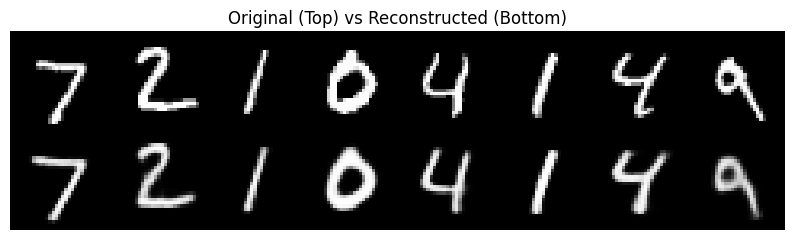

Generation (256)


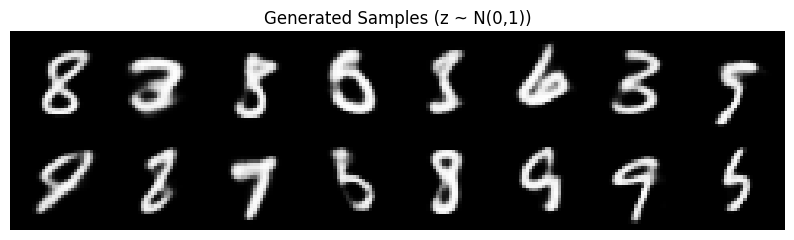

Interpolation (256)


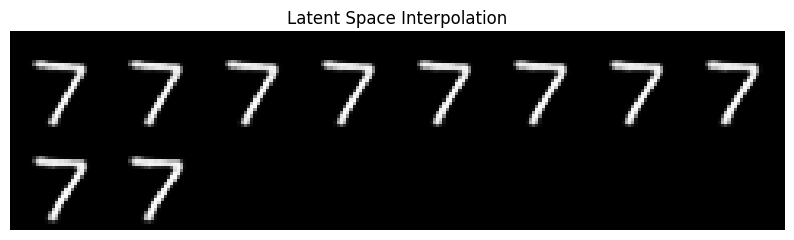

In [10]:
# Visualizations for latent_dim = 256
print("Reconstruction (256)")
reconstruct(vae_256, test_loader)

print("Generation (256)")
generate(vae_256)

print("Interpolation (256)")
interpolate(vae_256, test_loader)

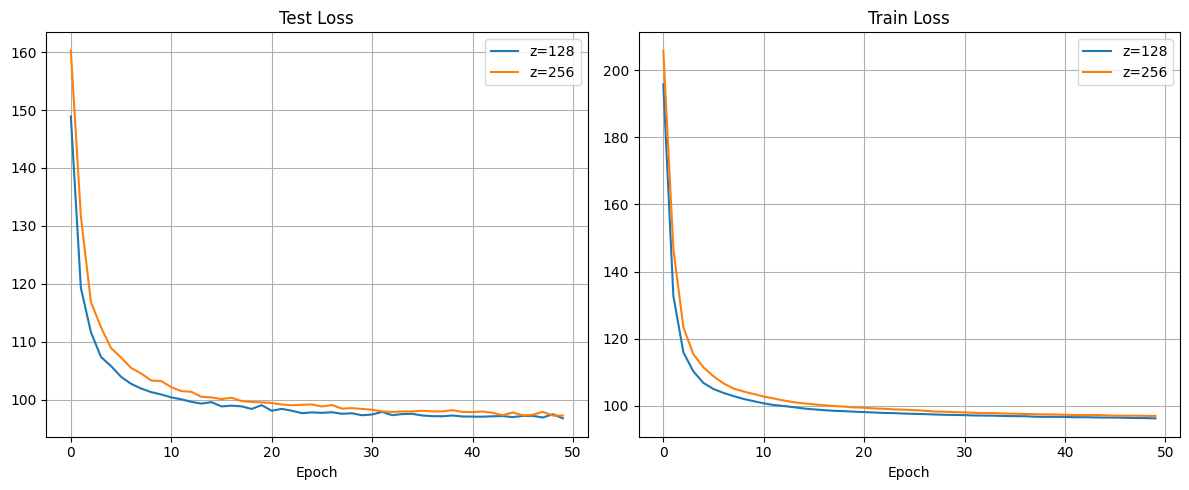

In [11]:
# Loss Curves Comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_128['test_loss'], label='z=128')
plt.plot(hist_256['test_loss'], label='z=256')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(hist_128['train_loss'], label='z=128')
plt.plot(hist_256['train_loss'], label='z=256')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Task 3: VAE Analysis Summary

### Latent Dimension = 128
* **Sharp reconstructions**
* **Smooth interpolation** between latent vectors
* **Good generation** of new samples

### Latent Dimension = 256
* Slightly better **reconstruction quality**
* More detailed digits in generation
* **Overkill for MNIST** (potential overfitting risk due to increased capacity)

### Recommendation
Use **$latent\_dim = 128$** for MNIST-it is **sufficient and efficient**.